### Données à classifier

In [1]:
from scipy import io
import scipy
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_dict = scipy.io.loadmat("Indian_pines_corrected.mat")

In [3]:
data = data_dict['indian_pines_corrected']

In [4]:
data.shape

(145, 145, 200)

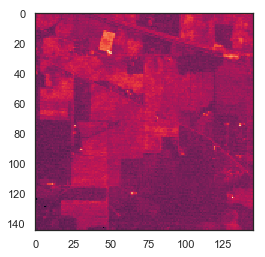

In [53]:
plt.imshow(data[:,:,3])

In [6]:
data_flatten = data.reshape(145*145, 200)

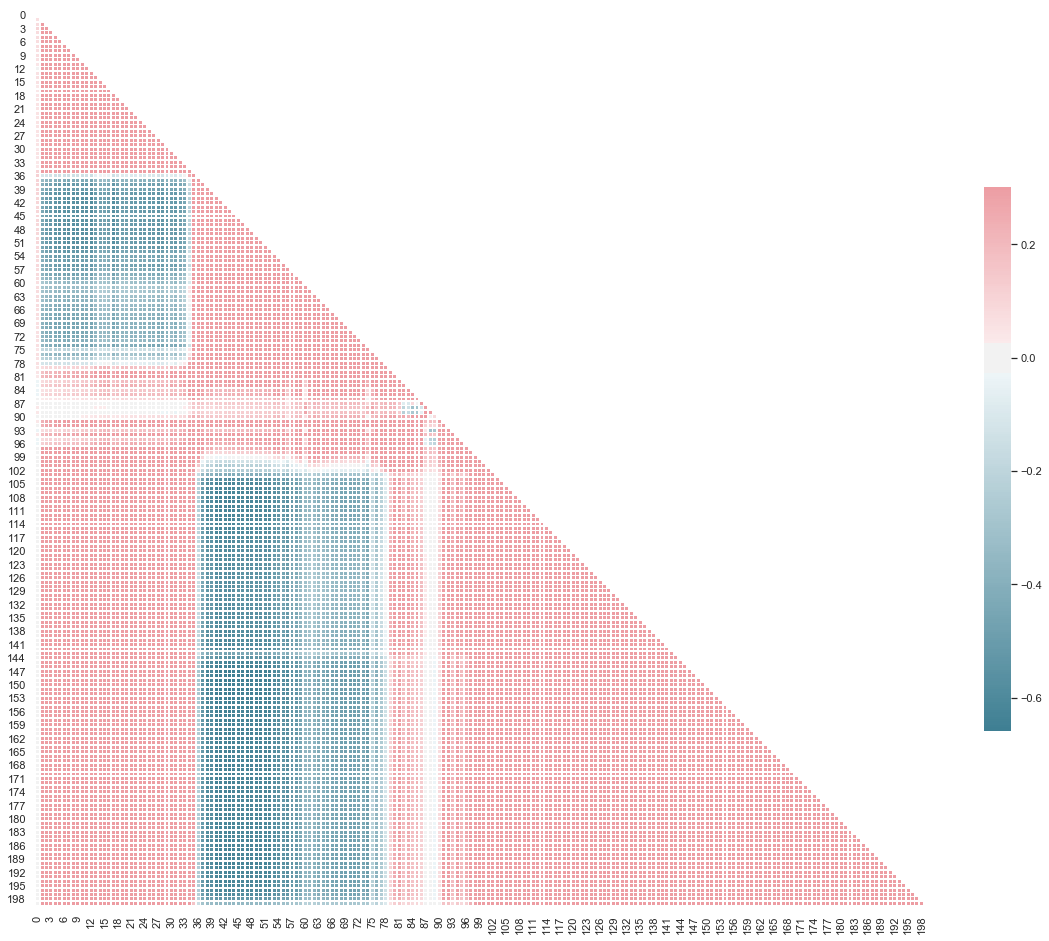

In [7]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset

d = pd.DataFrame(data=data_flatten,
                 columns=range(200))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Vérité de terrain

In [8]:
train_data = np.load("train_data.npy")
test_data = np.load("test_data.npy")

In [9]:
train_data.shape

(145, 145)

In [10]:
test_data.shape

(145, 145)

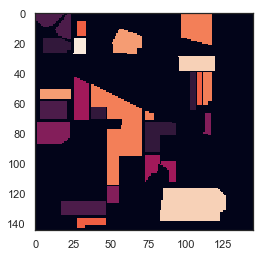

In [11]:
plt.imshow(train_data[:,:])

In [55]:
train_data[120,100]

14

In [12]:
count=0
for i in range(145):
    for j in range(145):
        if (test_data[i,j]==16):
            count = count+1
count

93

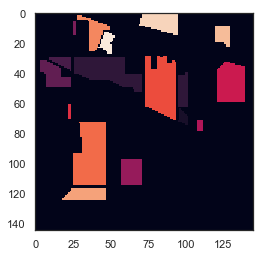

In [13]:
plt.imshow(test_data[:,:])

In [14]:
np.unique(train_data)

array([ 0,  2,  3,  5,  6, 10, 11, 12, 14, 15], dtype=uint8)

In [15]:
np.unique(test_data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

## LOL RANDOM FOREST

In [16]:
data.shape
#shape des datas

(145, 145, 200)

In [61]:
#Fonction de nettoyage de la donnée de test:
def nettoyage(Data_train,Data_test):
    #Numpy Array * Numpy Array -> Numpy Array
    
    #Hypothèse : bien mettre la donnée d'entrainement en premier. 
    
    #Notes : Cette fonction a le but d'éliminer les classes de test non représentées dans la bdd d'entrainement. 
    
    
    #Première partie de la fonction : déterminer les classes de test non représentées dans la bdd d'entrainement.
    #train_dict : np array
    train_dict = np.unique(Data_train)
    
    #test_dict : np array
    test_dict = np.unique(Data_test)
    
    #diff : list
    diff = []
    
    for i in range(test_dict.size):
        #flag = bool
        flag = False
        for j in range(train_dict.size):
            if test_dict[i]==train_dict[j]:
                flag = True
        if flag == False:
            diff.append(test_dict[i])
        
    
    #Fin première partie
    
    #Seconde partie : mettre les données non représentées à 0:
    
    #Resultat : np array
    Resultat = np.copy(Data_test)
    
    for i in range(len(diff)):
        for j in range(test_data.shape[0]):
            for k in range(test_data.shape[1]):
                if test_data[j,k]==diff[i]:
                    Resultat[j,k]=0
    return Resultat
    
            

In [18]:
#Fonction de remplacement des données pour entraînement:
def remplacement(Data,DataFrame_Train):
    #Numpy Array * Panda DataFrame -> Numpy Array
    
    #Hypothèse : le tableau Numpy et la DataFrame ont la même hauteur et même largeur
    
    #notes : Cette fonction prend en argument une image hyperspectrale ainsi que l'entraînement, puis remplace 
    # les valeurs de non-interêt dans l'image par des zeros
    
    #resultat : numpy Array
    resultat = np.copy(Data)
    
    #shape : tuple
    shape = Data.shape
    
    #values : numpy Array
    values = DataFrame_Train.values
    
    for k in range(shape[2]):
        for i in range(shape[0]):
            for j in range(shape[1]):
                if values[i,j]==0:
                    resultat[i,j,k]=0
    
    return resultat

In [19]:
#Fonction de mise en forme des données dans une matrice
def mise_en_forme(Data):
    #Numpy Array(i,j,k) -> PandaData Frame * Liste de Tuple
    #Hypothèse
    
    #Notes : Cette fonction prend en argument nos données pixel par pixel et couche par couche puis va constituer une
    #matrice contenant uniquement les valeurs utiles, et un dictionnaire permettant de reconstituer la base de donnée
    #originale.
    
    #shape : tuple
    shape = Data.shape
    
    #liste : liste de tuple
    liste = []
    
    #count : int
    count = 0
    
    #La partie qui suit permet de compter le nombre d'élément interessant dans une couche de Data,
    #Et de renseigner leur position dans le dictionnaire
    for i in range(shape[0]):
        for j in range(shape[1]):
            if Data[i,j,0]!=0:
                count = count+1
                liste.append((i,j))
    
    
    #resultat : Numpy Array
    resultat = np.ones((count,shape[2]))
    
    
    #On remplit!
    for k in range(shape[2]):
    #Réinitialisation du compteur:
        count=0
        for i in range(shape[0]):
            for j in range(shape[1]):
            
                if Data[i,j,k]!=0:
                    
                    resultat[count,k]=Data[i,j,k]
                    count=count+1
    
    return [resultat,liste] 

In [20]:
#Fonction de mise en forme des données dans une matrice, pour les données d'entraînement.
def mise_en_forme_train(Data):
    #Numpy Array(i,j,k) -> PandaData Frame * Liste de Tuple
    #Hypothèse
    
    #Notes : Cette fonction prend en argument nos données pixel par pixel et couche par couche puis va constituer une
    #matrice contenant uniquement les valeurs utiles, et un dictionnaire permettant de reconstituer la base de donnée
    #originale.
    
    #shape : tuple
    shape = Data.shape
    
    #liste : liste de tuple
    liste = []
    
    #count : int
    count = 0
    
    #La partie qui suit permet de compter le nombre d'élément interessant dans une couche de Data,
    #Et de renseigner leur position dans le dictionnaire
    for i in range(shape[0]):
        for j in range(shape[1]):
            if Data[i,j]!=0:
                count = count+1
                liste.append((i,j))
    
    
    #resultat : Numpy Array
    resultat = np.ones((count,1))
    
    
    #On remplit!
    count=0
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            if Data[i,j]!=0:
                    
                resultat[count]=Data[i,j]
                count=count+1
    
    return [resultat,liste] 

In [21]:
#Fonction permettant la reconstruction de l'image des classes
def reconstruction(Array,Dict,Size):
    #Np array * Tuple list -> Np Array
    #Hypothèses : le np array et la liste doivent être de même taille.
    
    #Notes : Cette fonction permet de reconstruire l'image des classes pour ce problème.
    
    #Resultat : Np array
    Resultat = np.zeros(Size)
    
    for i in range(len(Dict)):
        Resultat[Dict[i][0],Dict[i][1]]=Array[i]
    
    return Resultat

In [22]:
#Fonction permettant le calcul de la précision
def precision(Array1,Array2):
    #np array * np array -> float
    
    #Resultat : float
    Resultat=0.0
    
    for i in range(len(Array1)):
        if (Array1[i] == Array2[i]):
            Resultat=Resultat+1
    Resultat=Resultat/len(Array1)
    
    return Resultat

In [64]:
#Mise en forme de la donnée
Data = data
#Mise en forme de la donnée d'entraînement
Data_Train = pd.DataFrame(data=train_data)
#Mise en forme de la donnée de test 
test_data=nettoyage(train_data,test_data)
Data_Test = pd.DataFrame(data=test_data)

In [65]:
#On remplace les données non-interessantes par des 0
Data_reshaped=remplacement(Data,Data_Train)

In [66]:
#On stocke les données dans notre super matrice de stockage
[Data_Matrix,Dict]=mise_en_forme(Data_reshaped)
#De même pour la donnée d'entrainement.
[Train_Matrix,DictTrain]=mise_en_forme_train(train_data)

## C'est parti

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
Model = RandomForestClassifier(n_estimators=100)

In [69]:
Model.fit(Data_Matrix,Train_Matrix)

/Users/mathysgrapotte/python_projects/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
#On remplace les données non-interessantes par des 0
Data_reshaped_Test=remplacement(Data,Data_Test)

In [71]:
#On stocke les données dans notre super matrice de stockage
[Data_Matrix_Test,Dict]=mise_en_forme(Data_reshaped_Test)
#De même pour la donnée d'entrainement.
[Test_Matrix,DictTrain]=mise_en_forme_train(test_data)

In [72]:
Verdict=Model.predict(Data_Matrix_Test)

In [73]:
Verdict_Final=reconstruction(Verdict,DictTrain,(145,145))

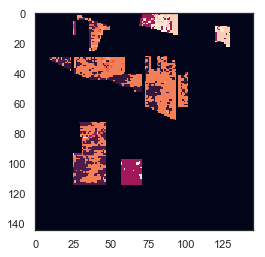

In [74]:
plt.imshow(Verdict_Final)

In [75]:
Verdict_Final[120,25]

0.0

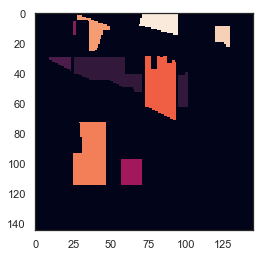

In [76]:
plt.imshow(Data_Test.values)

In [77]:
precision(Verdict,Test_Matrix)

0.3141809290953545

In [37]:
Data_Test.values[40,10]

4

### Annalyse des résultats : 
Il semblerait ici que l'algorithme random forest prédise la classe 11 (Soja - Minimum Tillage) en masse. On note également le carré en bas à droite qui est correctement prédit, appartient à la classe 6 (Herbe, arbre). Erreur de prédiction sur la classe 13 (qui ne devrait même pas être là) en bas par la classe 15 (divers).

### On essaye d'autres trucs

In [78]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
neigh = KNeighborsClassifier(n_neighbors=500)

In [80]:
neigh.fit(Data_Matrix,Train_Matrix)

/Users/mathysgrapotte/python_projects/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=500, p=2,
           weights='uniform')

In [81]:
wouuu = neigh.predict(Data_Matrix_Test)

In [82]:
allez = reconstruction(wouuu,DictTrain,(145,145))

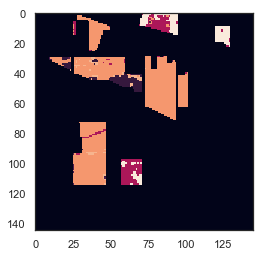

In [83]:
plt.imshow(allez)

In [84]:
precision(wouuu,Test_Matrix)

0.3719437652811736